# Human Activity Recognition
As the name suggests, We have identify and recognize human activity from a video
source and classify it based on the activity thus performed. 

## Dataset repositry and some insights on data.

Site: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones


So far, these are the signals we've:
* tBodyAcc-XYZ
* tGravityAcc-XYZ
* tBodyAccJerk-XYZ
* tBodyGyro-XYZ
* tBodyGyroJerk-XYZ
* tBodyAccMag
* tGravityAccMag
* tBodyAccJerkMag
* tBodyGyroMag
* tBodyGyroJerkMag
* fBodyAcc-XYZ
* fBodyAccJerk-XYZ
* fBodyGyro-XYZ
* fBodyAccMag
* fBodyAccJerkMag
* fBodyGyroMag
* fBodyGyroJerkMag

The aforementioned signals can be used to estimate a set of variables. i.e., we'll estimate the attributes listed below for each signal we've recorded thus far.
* mean(): Mean value
* std(): Standard deviation
* mad(): Median absolute deviation
* max(): Largest value in array
* min(): Smallest value in array
* sma(): Signal magnitude area
* energy(): Energy measure. Sum of the squares divided by the number of values.
* iqr(): Inter-quartile range
* entropy(): Signal entropy
* arCoeff(): Auto-regression coefficients with Burg order equal to 4
* correlation(): correlation coefficient between two signals
* maxInds(): index of the frequency component with largest magnitude
* meanFreq(): Weighted average of the frequency components to obtain a mean frequency
* skewness(): skewness of the frequency domain signal
* kurtosis(): kurtosis of the frequency domain signal
* bandsEnergy(): Energy of a frequency interval within the 64 bins of the FFT of each window.
* angle(): Angle between to vectors.

By averaging the signals in a single window sample, we can get some alternative vectors. On the angle() variable, these are used.
* gravityMean
* tBodyAccMean
* tBodyAccJerkMean
* tBodyGyroMean
* tBodyGyroJerkMean



Our goal is to forecast one of the six activities that a Smartphone user is conducting at the 2.56 Seconds time window utilizing either human designed 561 feature data or raw features of 128 reading.

These activites are encoded as follows:
1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LYING

TODO:
* On these 561 sized domain expert engineered features, we will apply classical Machine Learning models.

For that to happen we have to follow and check some steps:
1. Reading the Data
2. Data cleaning
3. Exploratry Data visualization ( To get some insights in data using some plots)
4. Apply various machine learning models.



In [2]:
!pip install hyperas

In [3]:
#importing rquired libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
warnings.simplefilter("ignore")

##Features Extracting 

In [4]:
#mounting the drive for importing thw data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#will make a list here and append all the features from text file as in number.
features = list()
with open("drive/MyDrive/Data/features.txt") as f:
    for line in f:
        features.append(line.split()[0])


## Reading train and test Data

In [9]:
#we are reading train data here
train_df = pd.read_csv("drive/MyDrive/Data/train/X_train.txt", delim_whitespace = True, names = features)

train_df["subject_id"] = pd.read_csv("drive/MyDrive/Data/train/subject_train.txt", header = None, squeeze = True) 

train_df["activity"] = pd.read_csv("drive/MyDrive/Data/train/y_train.txt", header = None, squeeze = True)
#using squeeze = True will get the data in pandas series format
activity = pd.read_csv("drive/MyDrive/Data/train/y_train.txt", header = None, squeeze = True)

#Here we are mapping activity to it's activity name
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})

train_df["activity_name"] = label_name

train_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,subject_id,activity,activity_name
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,-0.871914,-0.995031,-0.995127,-0.994640,-0.996060,-0.995866,-0.995031,-0.999973,-0.993755,-1.000000,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,-0.576159,-0.829711,0.843609,0.682401,0.837869,-0.986093,-0.999976,-0.999736,-0.999504,-0.997180,-0.983799,-0.986007,-0.627446,-0.850930,-0.911872,0.061436,0.074840,0.198204,-0.264307,0.072545,-0.155320,0.323154,-0.170813,0.294938,-0.306081,0.482148,-0.470129,-0.305693,-0.362654,0.507459,...,1.000000,0.678921,-0.701131,-0.909639,-0.989413,-0.987836,-0.986850,-0.986749,-0.996199,-0.989413,-0.999876,-0.989136,-0.720891,-1.000000,-0.035684,-0.230091,-0.511217,-0.995221,-0.995237,-0.995722,-0.995273,-0.995732,-0.995221,-0.999974,-0.995226,-0.955696,-0.936508,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,-0.569174,-0.824705,0.849095,0.683250,0.837869,-0.992653,-0.999991,-0.999856,-0.999757,-0.998004,-0.981232,-0.991325,-0.786553,-0.559477,-0.761434,0.313276,-0.131208,0.191161,0.086904,0.257615,-0.272505,0.434728,-0.315375,0.439744,-0.269069,0.179414,-0.088952,-0.155804,-0.189763,0.599213,...,-1.000000,0.559058,-0.528901,-0.858933,-0.991433,-0.989059,-0.987744,-0.991462,-0.998353,-0.991433,-0.999902,-0.989321,-0.763372,-0.897436,-0.273582,-0.510282,-0.830702,-0.995093,-0.995465,-0.995279,-0.995609,-0.997418,-

In [10]:
print("Training data size= {}".format(train_df.shape))

Training data size= (7352, 564)


In [12]:
#reading test data
test_df = pd.read_csv("drive/MyDrive/Data/test/X_test.txt", delim_whitespace = True, names = features)

test_df["subject_id"] = pd.read_csv("drive/MyDrive/Data/test/subject_test.txt", header = None, squeeze = True) 

test_df["activity"] = pd.read_csv("drive/MyDrive/Data/test/y_test.txt", header = None, squeeze = True)
#using squeeze = True will get the data in pandas series format
activity = pd.read_csv("drive/MyDrive/Data/test/y_test.txt", header = None, squeeze = True)

#Here we are mapping activity to it's activity name
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})

test_df["activity_name"] = label_name

test_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,subject_id,activity,activity_name
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,-0.554577,-0.466223,0.717208,0.635502,0.789497,-0.877764,-0.997766,-0.998414,-0.934345,-0.975669,-0.949824,-0.830478,-0.168084,-0.378996,0.246217,0.521204,-0.487793,0.482280,-0.045462,0.211955,-0.134894,0.130858,-0.014176,-0.105971,0.073544,-0.171516,0.040063,0.076989,-0.490546,-0.709003,...,-1.000000,-0.035356,-0.254248,-0.700326,-0.770610,-0.797113,-0.764485,-0.820188,-0.937959,-0.770610,-0.970958,-0.798387,0.179435,-1.000000,-0.047391,-0.467849,-0.761326,-0.890165,-0.907308,-0.895301,-0.917883,-0.909829,-0.890165,-0.994105,-0.898022,-0.234815,-1.000000,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,-0.554577,-0.806013,0.768031,0.683698,0.796706,-0.969097,-0.999580,-0.999646,-0.997720,-0.994006,-0.973637,-0.950720,-0.302437,-0.348243,-0.404785,0.507492,-0.156495,0.040674,0.272991,0.197566,-0.194556,0.411411,-0.340466,0.077555,-0.084024,0.035305,-0.010083,-0.104983,-0.429134,0.399177,...,-1.000000,-0.491213,-0.215404,-0.666004,-0.924461,-0.916774,-0.919383,-0.917983,-0.991121,-0.924461,-0.995727,-0.933127,-0.218860,-1.000000,-0.031474,-0.090655,-0.461801,-0.951977,-0.938212,-0.938008,-0.949922,-0.986902,-0.951977,-0.998272,-0.951255,-0.431053,-1.000000,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,-0.568512,-0.799116,0.848305,0.667864,0.822442,-0.976782,-0.999954,-0.999570,-0.998720,-0.993456,-0.974266,-0.964976,-0.617916,-0.695490,-0.536693,0.242147,-0.114997,0.032703,0.192385,-0.011945,-0.063363,0.470819,-0.507395,0.188536,-0.231575,0.632120,-0.550708,0.305653,-0.323848,0.279786,...,-1.000000,0.140729,-0.206062,-0.639809,-0.975209,-0.973998,-0.967097,-0.982849,-0.997663,-0.975209,-0.999504,-0.968260,-0.561266,-0.897436,-0.168805,-0.662317,-0.925364,-0.985689,-0.983273,-0.983422,-0.986857,-0.989609,-0.985689,-0.999831,-0.986148,-0.809976,-0.936508,0.062891,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,5,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,-0.568512,-0.799116,0.848305,0.667864,0.822442,-0.974418,-0.999953,-0.999330,-0.998933,-0.995236,-0.978739,-0.969982,-0.749578,-0.899226,-0.553813,0.174684,-0.051332,0.034200,0.153639,0.030767,-0.129277,0.446100,-0.419496,0.271493,-0.225769,0.416376,-0.286445,-0.063792,-0.167111,0.544916,...,-0.968254,0.148649,-0.619905,-0.887178,-0.976297,-0.971248,-0.966029,-0.974878,-0.996129,-0.976297,-0.999458,-0.975174,-0.566733,-0.948718,-0.285636,-0.446478,-0.756855,-0.985562,-0.985843,-0.984217,-0.988566,-0.992021,-0.985562,-0.999850,-0.984015,-0.849081,-0.936508,0.116695,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,5,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,-0.560831,-0.825894,0.849179,0.670700,0.829897,-0.975283,-0.999954,-0.999467,-0.998823,-0.993498,-0.967032,-0.976257,-0.590576,-0.740206,-0.799419,0.115570,-0.028923,-0.032804,0.294340,0.000630,-0.045272,0.168419,-0.068156,0.074384,0.027138,-0.145931,-0.050197,0.235151,0.290487,0.457718,...,-0.809524,0.422249,-0.543096,-0.831313,-0.977007,-0.969619,-0.968915,-0.973746,-0.996970,-0.977007,-0.999429,-0.976111,-0.555564,-1.000000,-0.349061,-0.319763,-0.691739,-0.990498,-0.990572,-0.988406,-0.992653,-0.992505,-0.

In [13]:
print("Test Data Size= {}".format(test_df.shape))

Test Data Size= (2947, 564)


#Data Cleaning 

In [14]:
# Null values check
print("Train data null values: "+str(train_df.isnull().sum().sum()))
print("Test data null values: "+str(test_df.isnull().sum().sum()))
# Duplicate values check
print("Train data duplicate values: "+str(sum(train_df.duplicated())))
print("Test data duplicate values: "+str(sum(test_df.duplicated())))

Train data null values: 0
Test data null values: 0
Train data duplicate values: 0
Test data duplicate values: 0


So here from above results we can say that we do notb have any null or duplicate values in data.

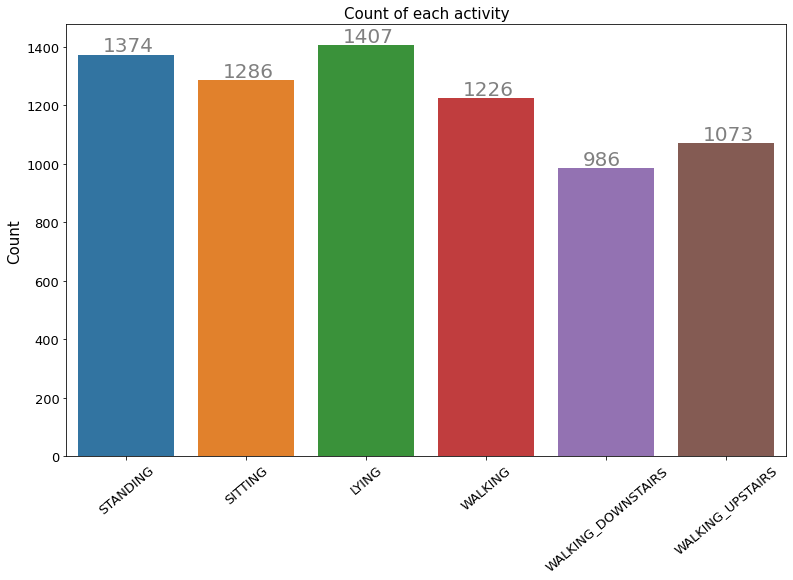

In [52]:
#Imbalance in data check
fig = plt.figure(figsize = (10, 6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each activity", fontsize = 15)
plt.tick_params(labelsize = 10)
sns.countplot(x = "activity_name", data = train_df)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+10, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("")
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 13)
plt.xticks(rotation = 40)
plt.show()

We can deduce from the following plot that our classes are nearly balanced.

## 5. Saving Dataframe for future use

In [58]:
train_df.to_csv("drive/MyDrive/Data/train/train_df.csv", index = False)
test_df.to_csv("drive/MyDrive/Data/test/test_df.csv", index = False)

In [59]:
train_df = pd.read_csv("drive/MyDrive/Data/train/train_df.csv")
test_df = pd.read_csv("drive/MyDrive/Data/test/test_df.csv")

## 6. Exploratory Data Analysis

* Sitting, Standing, Lying are static activities 
* Walking, Walking_Downstairs, Walking_Upstairs are dynamic activities

Magnitude of Body Accelerator Mean Plot

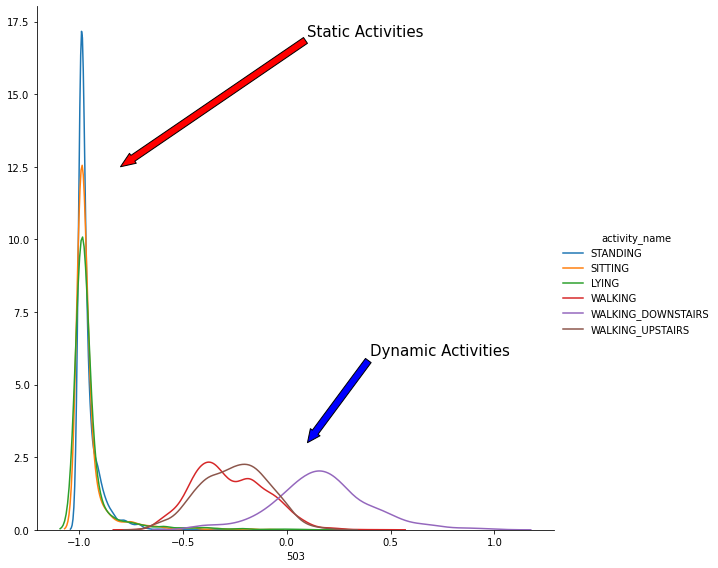

In [44]:
#here 503 refers to Magnitude of Body Accelerator or tBodyAccMagmean as in column name
facetgrid = sns.FacetGrid(data = train_df, hue = "activity_name", size = 8)
facetgrid.map(sns.distplot, "503", hist =
              False).add_legend()
plt.annotate('Static Activities', xy=(-0.8, 12.5), xytext=(0.1, 17),
            arrowprops=dict(facecolor='red', width = 7, headlength = 15), size = 15)
plt.annotate('Dynamic Activities', xy=(0.1, 3), xytext=(0.4, 6),
            arrowprops=dict(facecolor='blue', width = 7, headlength = 13), size = 15)
plt.show()

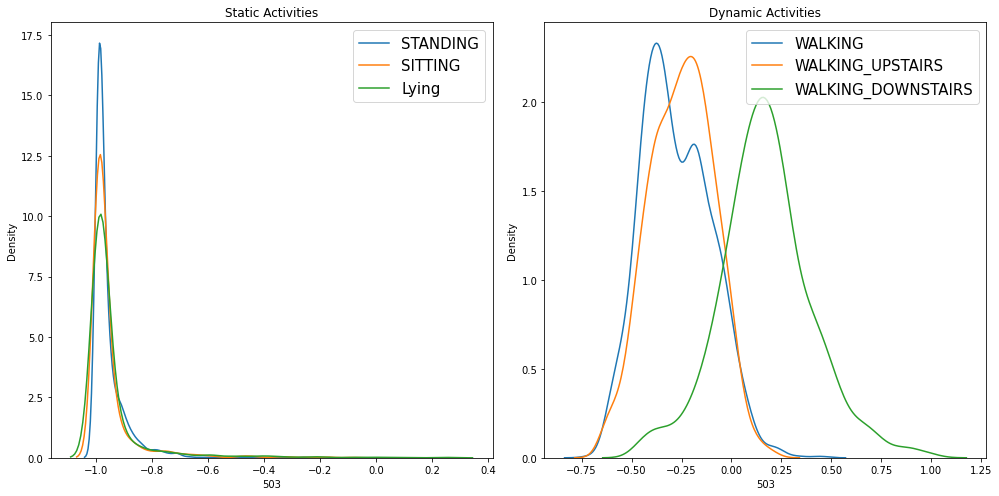

In [45]:
#Let's look into "tBodyAccMagmean" individually for static and dynamic activity to see how they compare.
df_standing = train_df[train_df["activity_name"] == "STANDING"]
df_sitting = train_df[train_df["activity_name"] == "SITTING"]
df_lying = train_df[train_df["activity_name"] == "LYING"]
df_walking = train_df[train_df["activity_name"] == "WALKING"]
df_walking_upstairs = train_df[train_df["activity_name"] == "WALKING_UPSTAIRS"]
df_walking_downstairs = train_df[train_df["activity_name"] == "WALKING_DOWNSTAIRS"]

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 7))

axes[0].set_title("Static Activities")
sns.distplot(df_standing["503"], hist = False, label = "STANDING", ax = axes[0])
sns.distplot(df_sitting["503"], hist = False, label = "SITTING", ax = axes[0])
sns.distplot(df_lying["503"], hist = False, label = "Lying", ax = axes[0])
axes[0].legend(fontsize = 15)

axes[1].set_title("Dynamic Activities")
sns.distplot(df_walking["503"], hist = False, label = "WALKING", ax = axes[1])
sns.distplot(df_walking_upstairs["503"], hist = False, label = "WALKING_UPSTAIRS", ax = axes[1])
sns.distplot(df_walking_downstairs["503"], hist = False, label = "WALKING_DOWNSTAIRS", ax = axes[1])
axes[1].legend(fontsize = 15)

plt.tight_layout()
plt.show()

Inference: We can see how well "tBodyAccMagmean"—which is the magnitude of the mean of body acceleration in time-domain measured by accelerometer—is able to distinguish static from dynamic activity from the two plots above. This demonstrates that domian professionals deliberately engineer features.


Accelerator Gravity Mean Plot

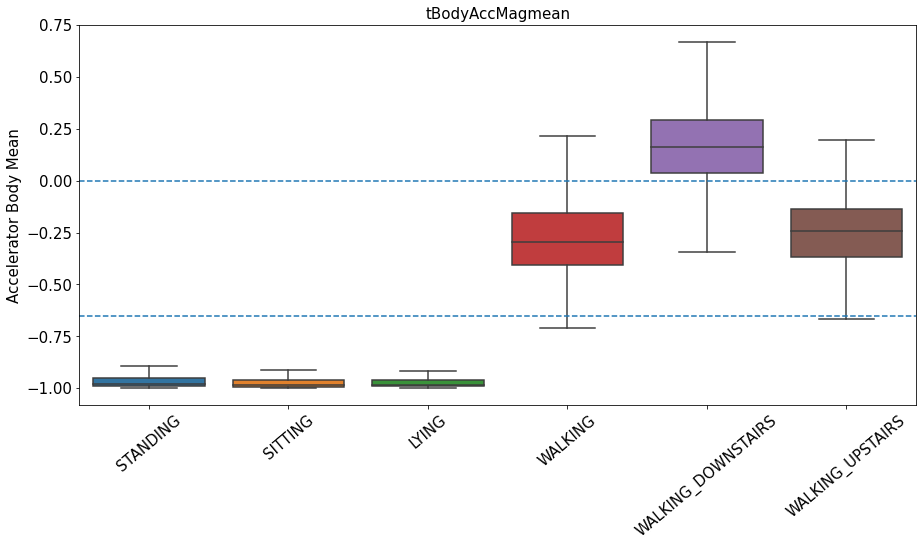

In [48]:
#using boxplot for getting some insights
#tAccMean = Accelerator Gravity Mean
#here 503 refers to Magnitude of Body Accelerator or tBodyAccMagmean as in column name
plt.figure(figsize = (15, 7))
sns.boxplot(x = "activity_name", y = "503", showfliers = False, data = train_df)
plt.axhline(y = -0.65, linestyle = "--")
plt.axhline(y = 0, linestyle = "--")
plt.title("tBodyAccMagmean", fontsize = 15)
plt.ylabel("Accelerator Body Mean", fontsize = 15)
plt.xlabel("Activity Name", fontsize = 15)
plt.xlabel("")
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

Inference:
* If tAccMean is < -0.8 then the Activities are static activities (Standing or Sitting or Laying).
* If tAccMean is > -0.6 then the Activities are dynamic activities (Walking or WalkingDownstairs or WalkingUpstairs).
* If tAccMean > 0.0 then the Activity is WalkingDownstairs.
* We can classify 75% the Acitivity labels with some errors.

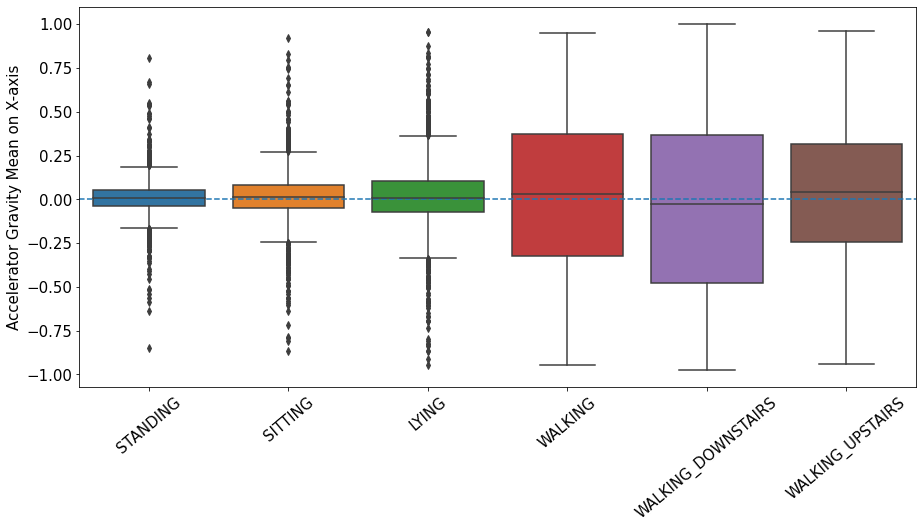

In [50]:
#Accelerator Gravity Mean on X-axis can be quite important
#here 555 refers to angleXgravitymean as in column name
plt.figure(figsize = (15, 7))
sns.boxplot(x = "activity_name", y = "555", showfliers = True, data = train_df)
plt.axhline(y = 0, linestyle = "--")
plt.ylabel("Accelerator Gravity Mean on X-axis", fontsize = 15)
plt.xlabel("")
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

Inference:
All are distributed almost same if acgravity mean > 0 then anything can turn out and vice versa.

## Applying T-SNE on Data
For exploring high dimensional data



In [52]:
def plt_tsne(perplexity, train_df):
    data = train_df.drop(["subject_id", "activity", "activity_name"], axis = 1)
    data_label = train_df["activity_name"]
    applying_tsne = TSNE(n_components = 2, perplexity = perplexity, n_iter = 1000, verbose = 2)
    reduced_dim = applying_tsne.fit_transform(data)
    d = {'Dimension_1': applying_tsne.embedding_[:,0], 'Dimension_2': applying_tsne.embedding_[:,1], "activities":data_label}
    df = pd.DataFrame(data = d)
    sns.set_style("whitegrid") 
    sns.lmplot("Dimension_1", "Dimension_2", df, hue = 'activities', markers=['|','o','_', ">", "<", "^"], fit_reg = False, size = 10, scatter_kws={'s':100})
    plt.title("TSNE Plot for Perplexity "+str(perplexity))
    plt.show()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.447s...
[t-SNE] Computed neighbors for 7352 samples in 36.804s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.961265
[t-SNE] Computed conditional probabilities in 0.069s
[t-SNE] Iteration 50: error = 114.0959625, gradient norm = 0.0203431 (50 iterations in 14.045s)
[t-SNE] Iteration 100: error = 97.6650238, gradient norm = 0.0172454 (50 iterations in 2.281s)
[t-SNE] Iteration 150: error = 93.2363892, gradient norm 

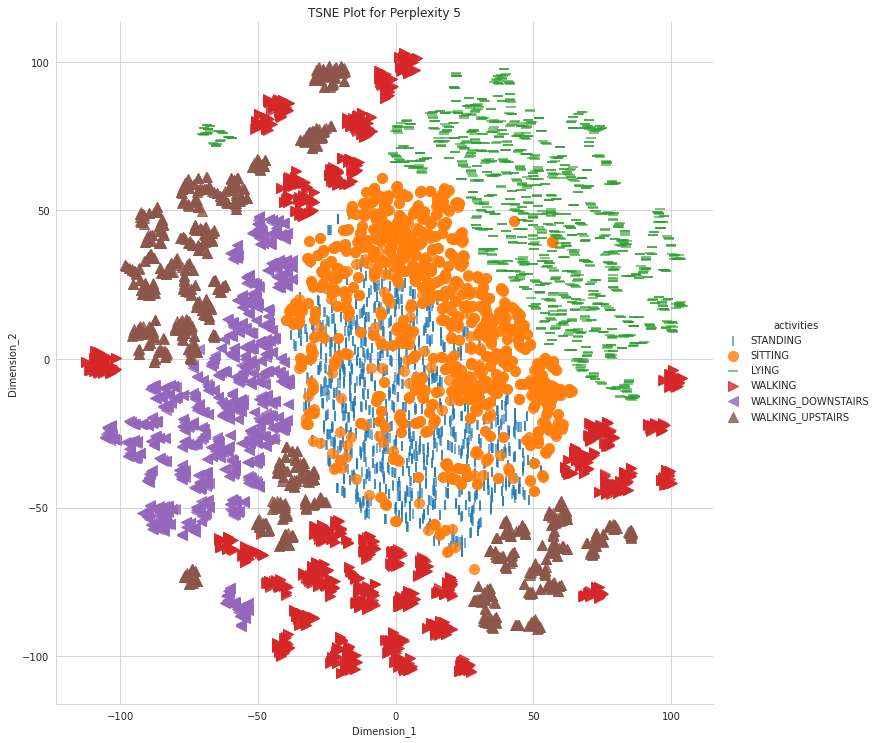

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.463s...
[t-SNE] Computed neighbors for 7352 samples in 36.867s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.133828
[t-SNE] Computed conditional probabilities in 0.122s
[t-SNE] Iteration 50: error = 105.7447357, gradient norm = 0.0209018 (50 iterations in 3.066s)
[t-SNE] Iteration 100: error = 90.8815613, gradient norm = 0.0098924 (50 iterations in 2.226s)
[t-SNE] Iteration 150: error = 87.5913086, gradient norm =

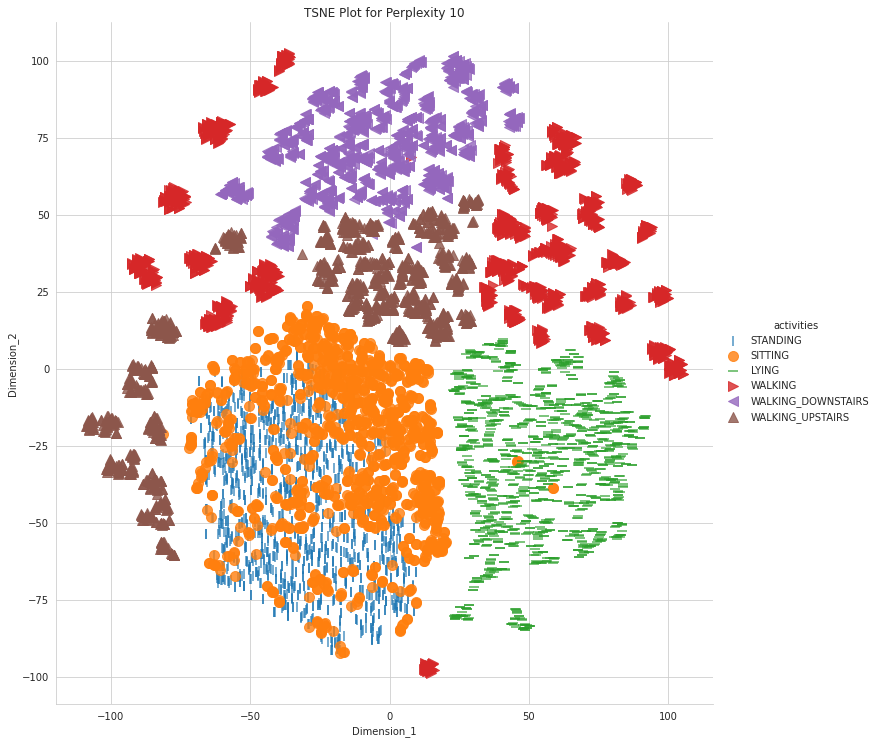

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.447s...
[t-SNE] Computed neighbors for 7352 samples in 37.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.274335
[t-SNE] Computed conditional probabilities in 0.241s
[t-SNE] Iteration 50: error = 96.1955719, gradient norm = 0.0314967 (50 iterations in 3.627s)
[t-SNE] Iteration 100: error = 83.7303619, gradient norm = 0.0077034 (50 iterations in 2.657s)
[t-SNE] Iteration 150: error = 81.7670898, gradient norm = 

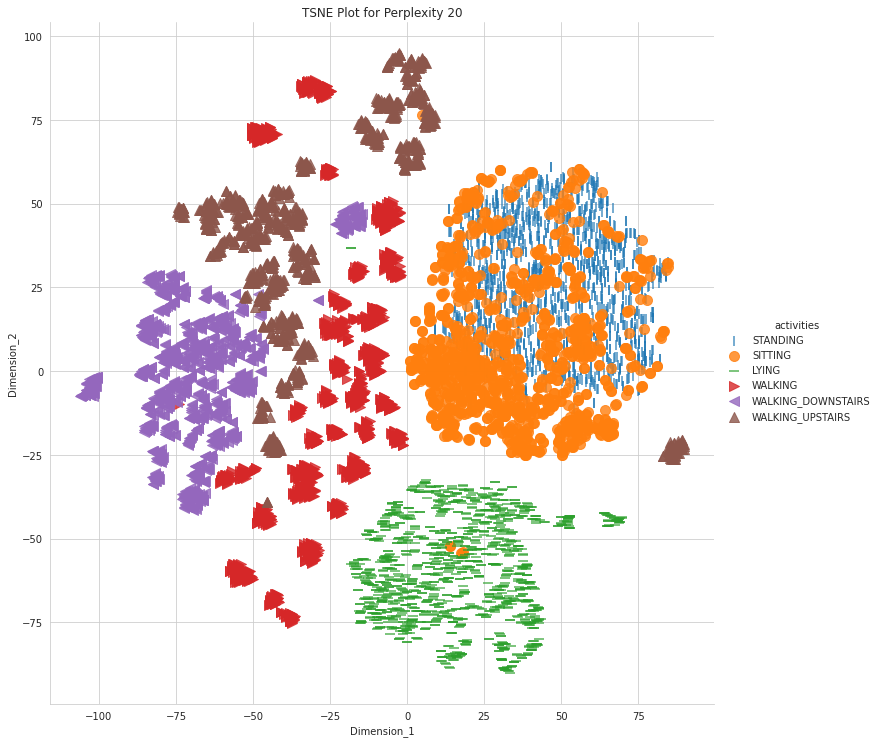

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.444s...
[t-SNE] Computed neighbors for 7352 samples in 38.370s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.399086
[t-SNE] Computed conditional probabilities in 0.477s
[t-SNE] Iteration 50: error = 89.3365173, gradient norm = 0.0179724 (50 iterations in 3.575s)
[t-SNE] Iteration 100: error = 78.2112885, gradient norm = 0.0051806 (50 iterations in 3.199s)
[t-SNE] Iteration 150: error = 76.8276062, gradient norm =

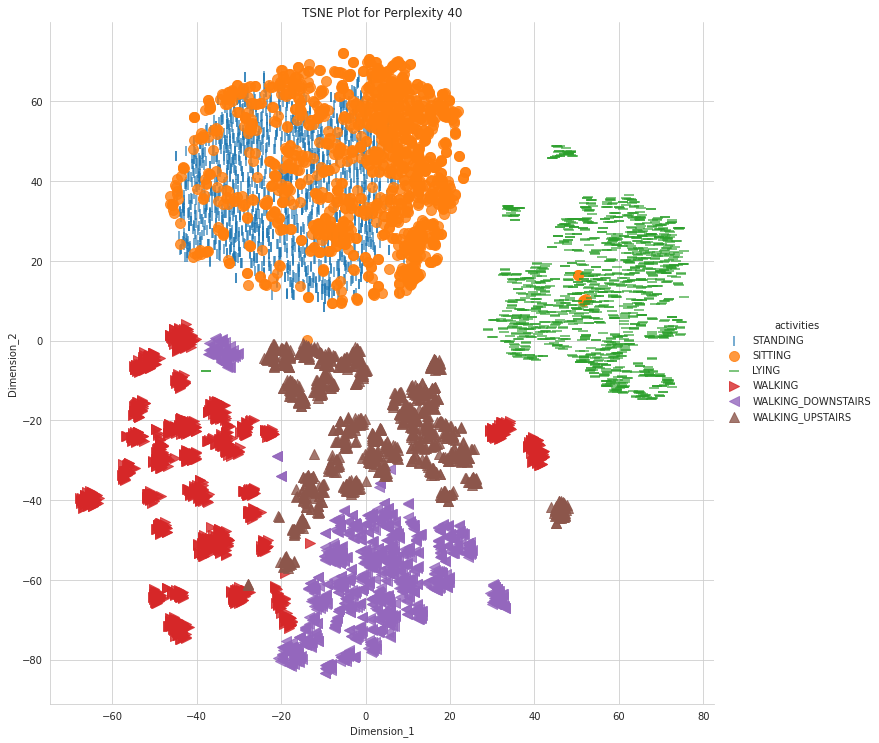

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.455s...
[t-SNE] Computed neighbors for 7352 samples in 41.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.559265
[t-SNE] Computed conditional probabilities in 1.193s
[t-SNE] Iteration 50: error = 77.0485077, gradient norm = 0.0316559 (50 iterations in 4.507s)
[t-SNE] Iteration 100: error = 68.5229340, gradient norm = 0.0040332 (50 iterations in 4.053s)
[t-SNE] Iteration 150: error = 68.0245361, gradient norm =

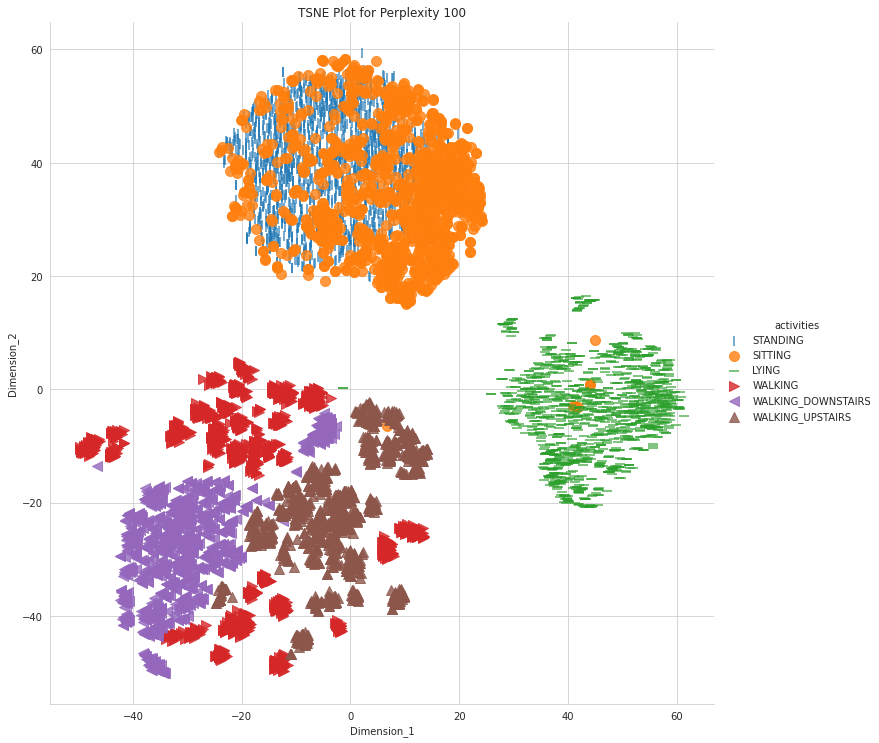

In [53]:
perplexities = [5, 10, 20, 40, 100]
for perplexity in perplexities:
    plt_tsne(perplexity, train_df)

Inference:
We can see from the TSNE plots above that, with the exception of STANDING and SITTING, all other activities are quite strongly separated.

## 8. Machine Learning Models

In [54]:
#train and test
x_train = train_df.drop(["subject_id", "activity", "activity_name"], axis = 1)
y_train = train_df["activity"]

x_test = test_df.drop(["subject_id", "activity", "activity_name"], axis = 1)
y_test = test_df["activity"]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7352, 561), (7352,), (2947, 561), (2947,))

In [56]:
#keeping a table where we will append model_name and accuracy
table = pd.DataFrame(columns = ["Model", "Accuracy(%)"])
def keeping_record(model_name, accuracy):
    global table
    table = table.append(pd.DataFrame([[model_name, accuracy]], columns = ["Model", "Accuracy(%)"]))
    table.reset_index(drop = True, inplace = True)

In [58]:
#defining function to print confusion matrix 
def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    sns.set(font_scale=1.5)
    
    labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
    
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(16,7))
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(16,7))
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

In [59]:
#By defining this we wil get accuracy of model it's best estimators and hyperpaaremterrs
def apply_model(cross_val, x_train, y_train, x_test, y_test, model_name):
    start = datetime.now()
    cross_val.fit(x_train, y_train)
    predicted_points = cross_val.predict(x_test)
    
    print("The total time spent setting hyperparameters and producing model predictions is (HH:MM:SS): {}\n".format(datetime.now() - start))
    accuracy = np.round(accuracy_score(y_test, predicted_points)*100, 2)
    
    
    print('|------Accuracy------|')
    print(str(accuracy)+"%\n")
    
    
    print('|------Best Estimator-------|')
    print("{}\n".format(cross_val.best_estimator_))

    print('|------Best Hyper-Parameters------|')
    print(cross_val.best_params_)
    
    keeping_record(model_name, accuracy)
    
    print("\n\n")
    
    print_confusionMatrix(y_test, predicted_points)

## 8.1 Logistic Regression

The total time spent setting hyperparameters and producing model predictions is (HH:MM:SS): 0:00:41.892093

|------Accuracy------|
96.5%

|------Best Estimator-------|
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

|------Best Hyper-Parameters------|
{'C': 100, 'penalty': 'l2'}





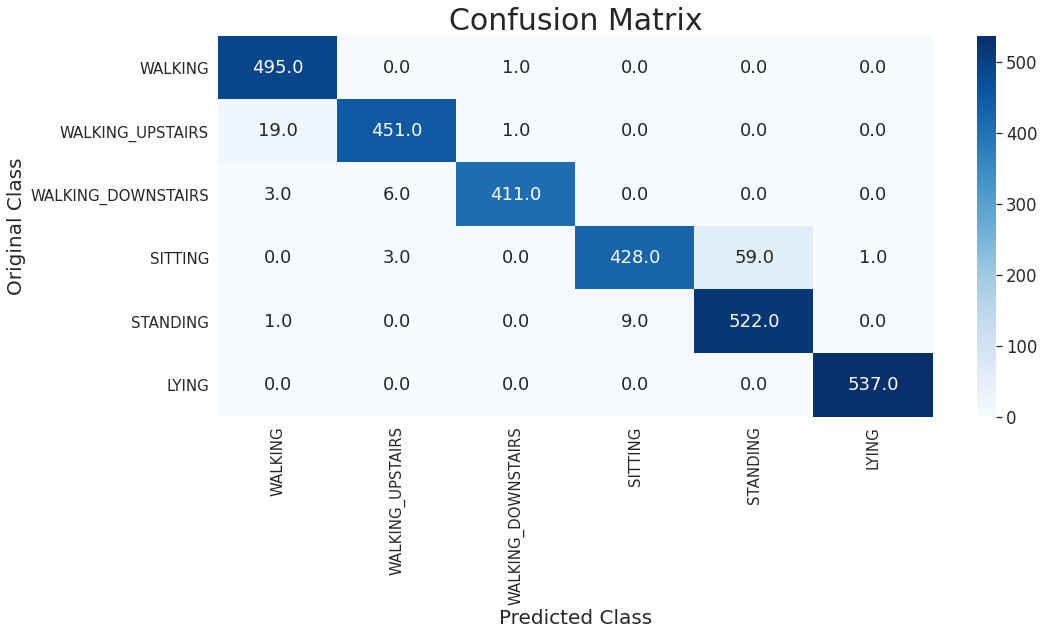

-----------------------------------------------------------------------------------------------------------------------------


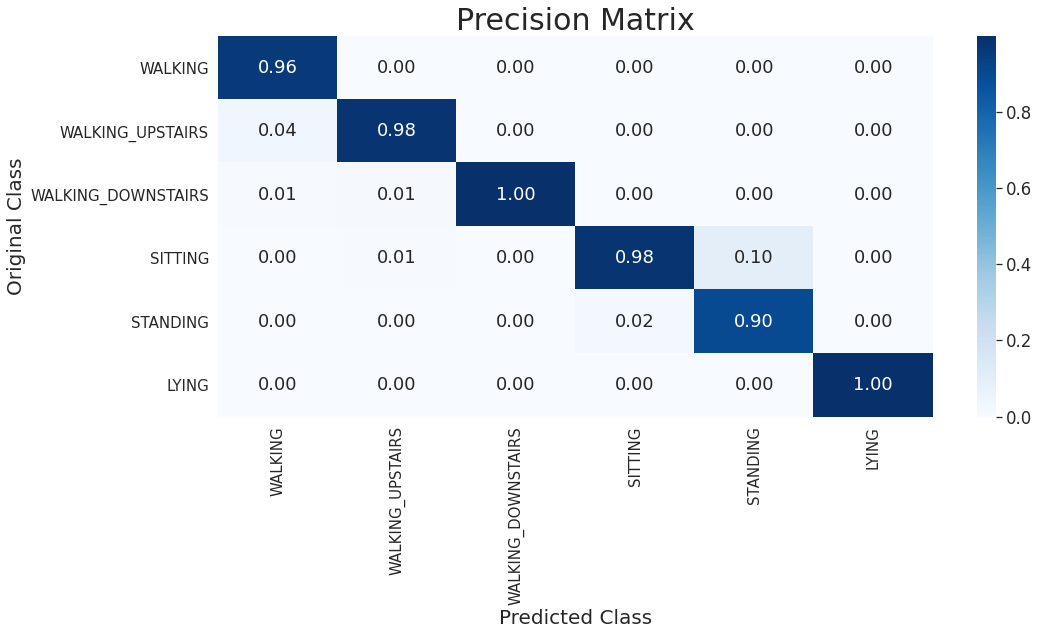

-----------------------------------------------------------------------------------------------------------------------------


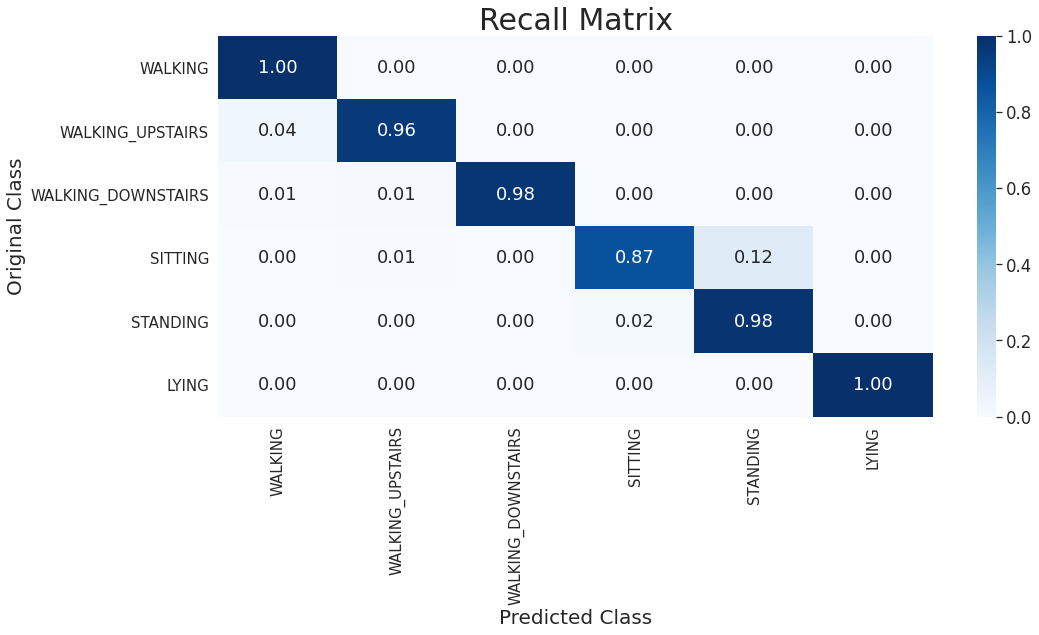

In [60]:
parameters = {"C": [0.001, 0.01, 0.1, 1, 10**1, 10**2, 10**3], "penalty": ["l1", "l2"]}
clf = LogisticRegression(multi_class = "ovr")
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "Logistic Regression")

## 8.2 Linear SVM

The total time spent setting hyperparameters and producing model predictions is (HH:MM:SS): 0:00:52.341244

|------Accuracy------|
96.57%

|------Best Estimator-------|
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

|------Best Hyper-Parameters------|
{'C': 1}





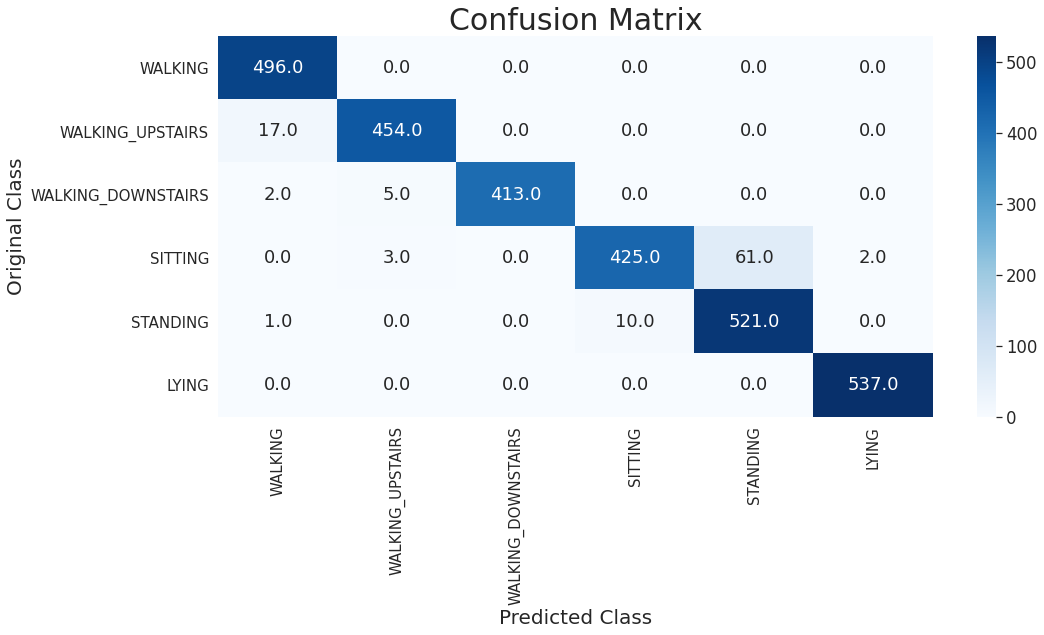

-----------------------------------------------------------------------------------------------------------------------------


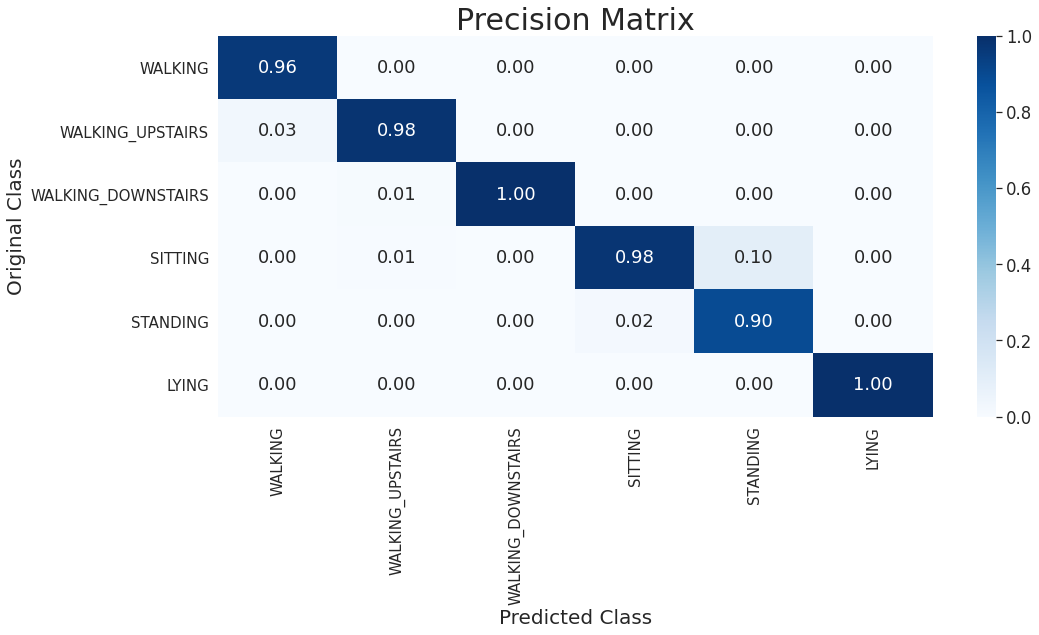

-----------------------------------------------------------------------------------------------------------------------------


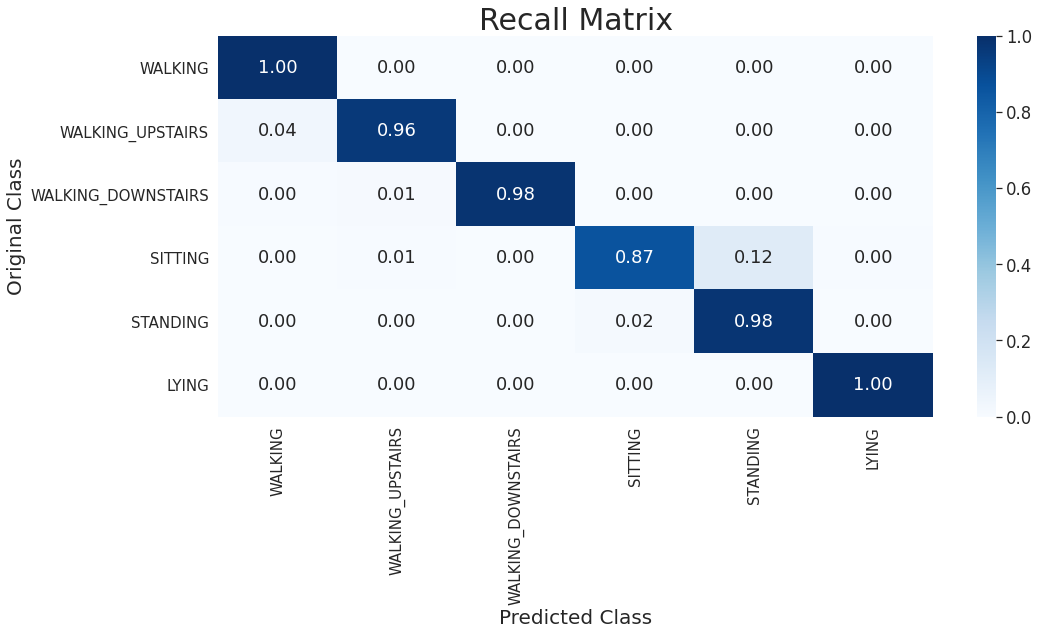

In [61]:
parameters = {"C": [0.001, 0.01, 0.1, 1, 10**1, 10**2, 10**3]}
clf = LinearSVC()
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "Linear SVM")

## 8.3 RBF SVM

The total time spent setting hyperparameters and producing model predictions is (HH:MM:SS): 0:05:11.438524

|------Accuracy------|
96.54%

|------Best Estimator-------|
SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

|------Best Hyper-Parameters------|
{'C': 100}





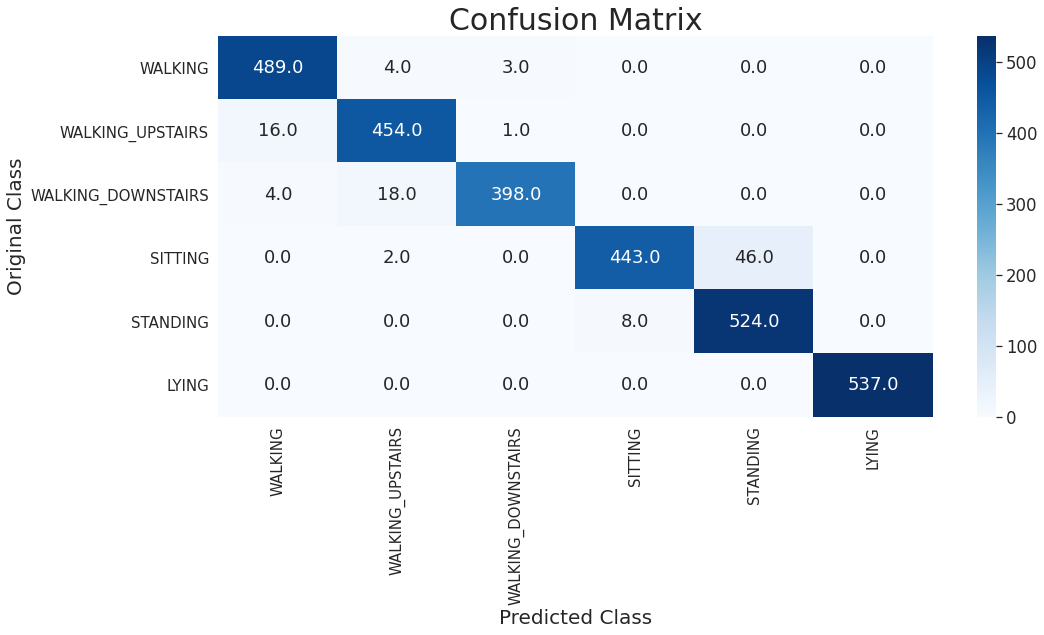

-----------------------------------------------------------------------------------------------------------------------------


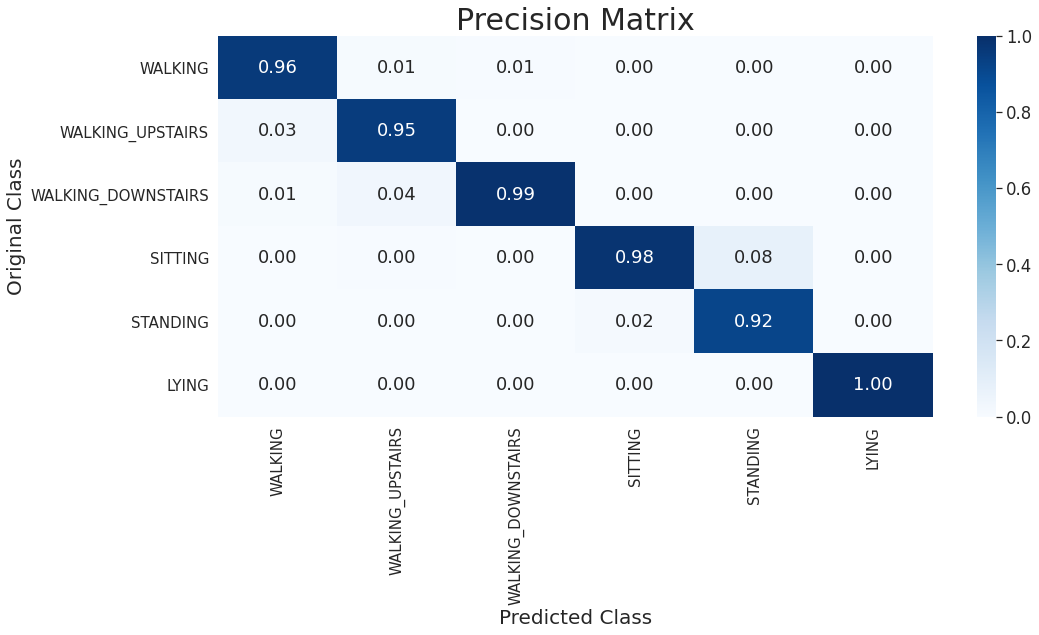

-----------------------------------------------------------------------------------------------------------------------------


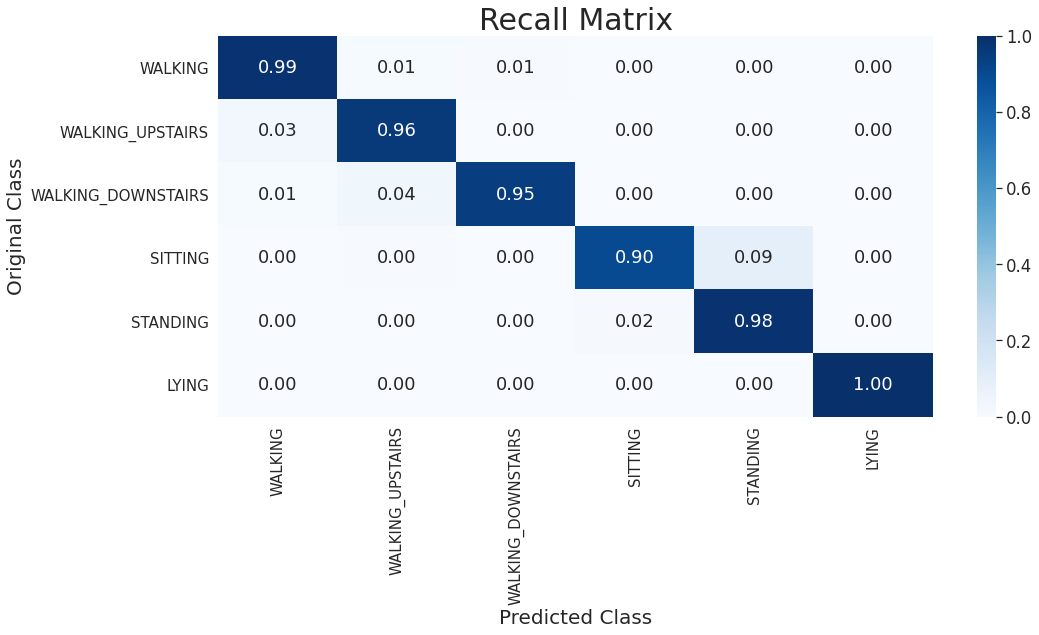

In [62]:
parameters = {"C": [0.001, 0.01, 0.1, 1, 10**1, 10**2, 10**3]}
clf = SVC()
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "RBF SVM")

## 8.4 Decision Trees

The total time spent setting hyperparameters and producing model predictions is (HH:MM:SS): 0:00:30.318126

|------Accuracy------|
87.04%

|------Best Estimator-------|
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

|------Best Hyper-Parameters------|
{'max_depth': 8}





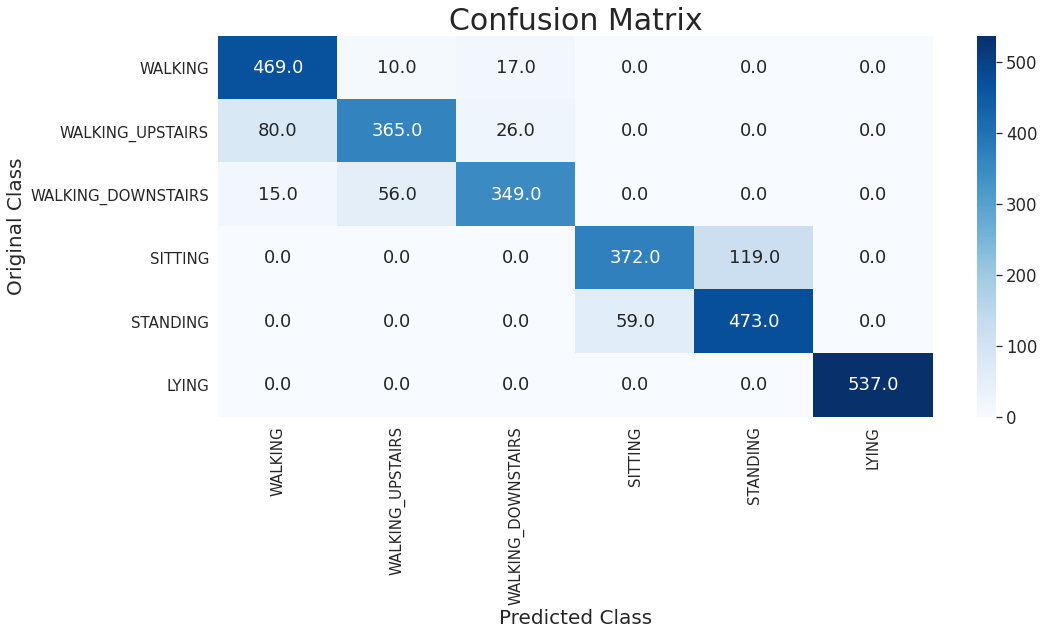

-----------------------------------------------------------------------------------------------------------------------------


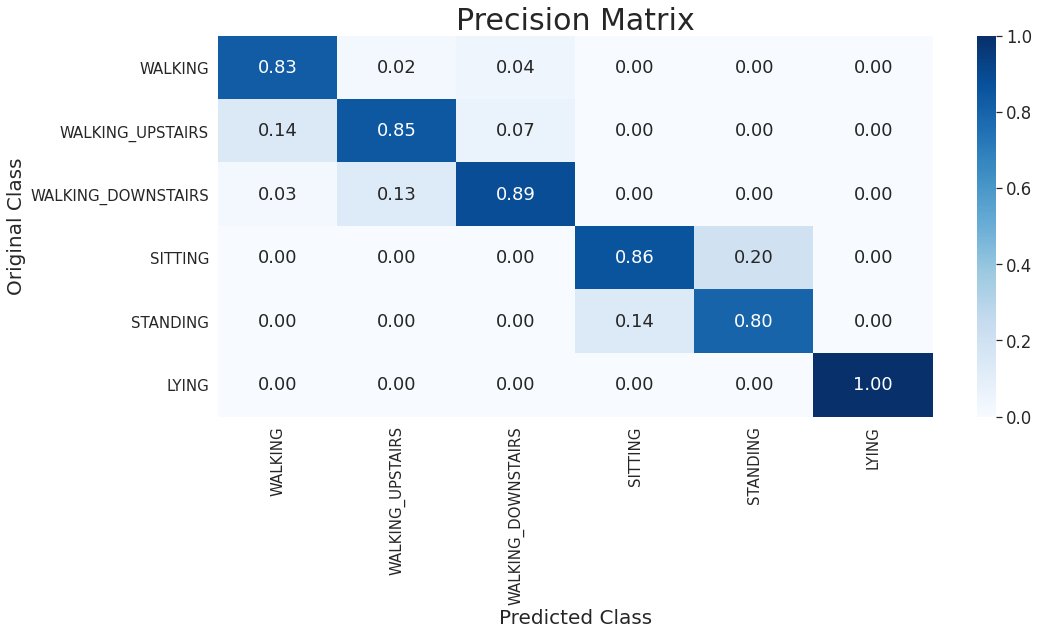

-----------------------------------------------------------------------------------------------------------------------------


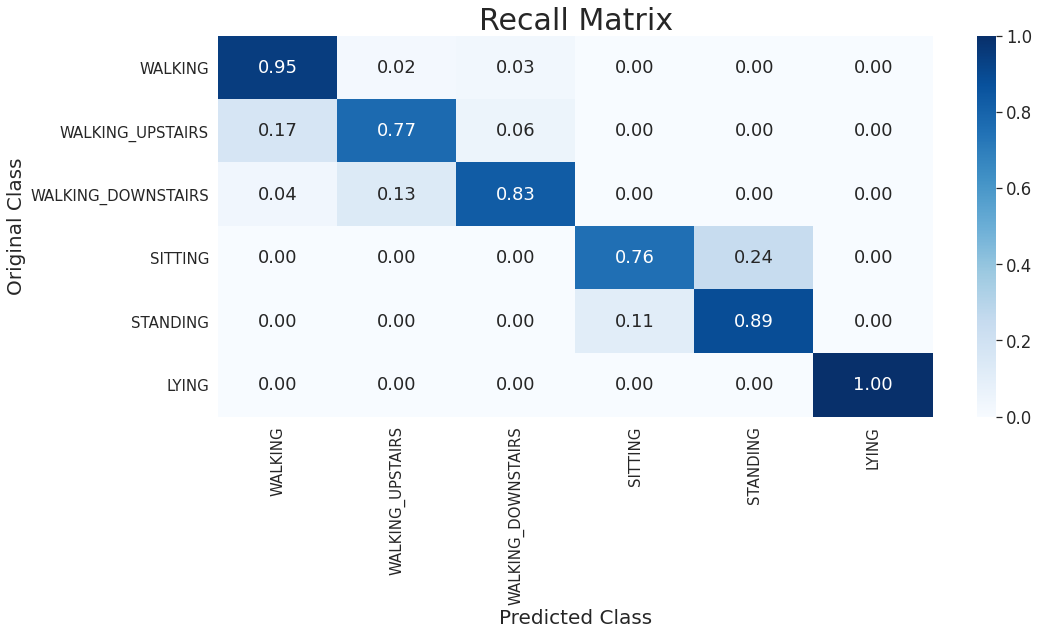

In [63]:
parameters = {"max_depth": [2, 3, 4, 5, 6, 7, 8]}
clf = DecisionTreeClassifier()
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "Decision Trees")

## 8.5 Random Forest

The total time spent setting hyperparameters and producing model predictions is (HH:MM:SS): 0:05:30.350990

|------Accuracy------|
92.74%

|------Best Estimator-------|
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

|------Best Hyper-Parameters------|
{'n_estimators': 100}





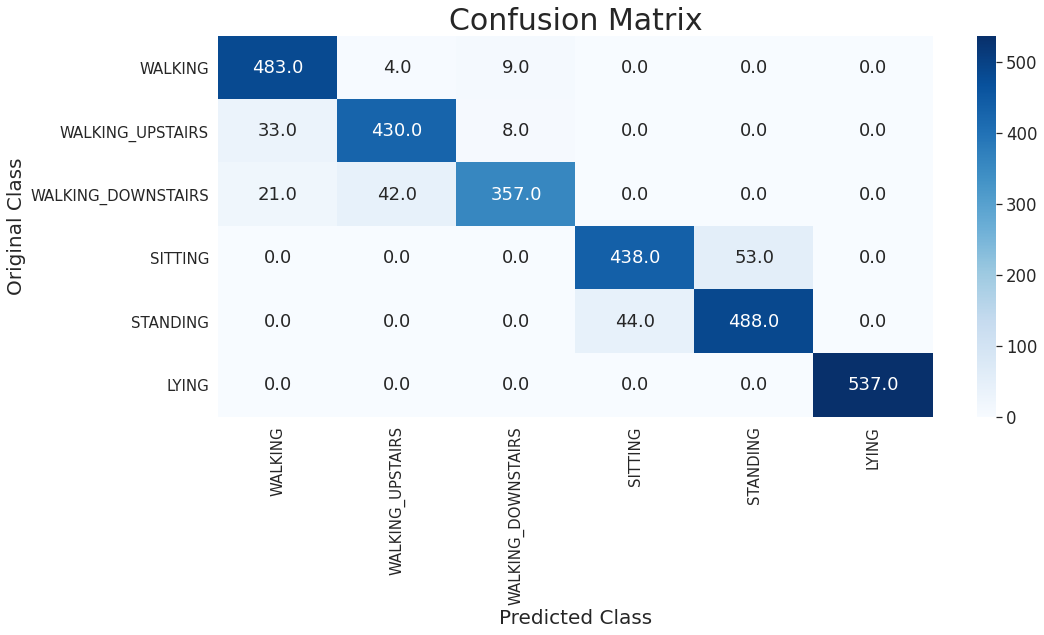

-----------------------------------------------------------------------------------------------------------------------------


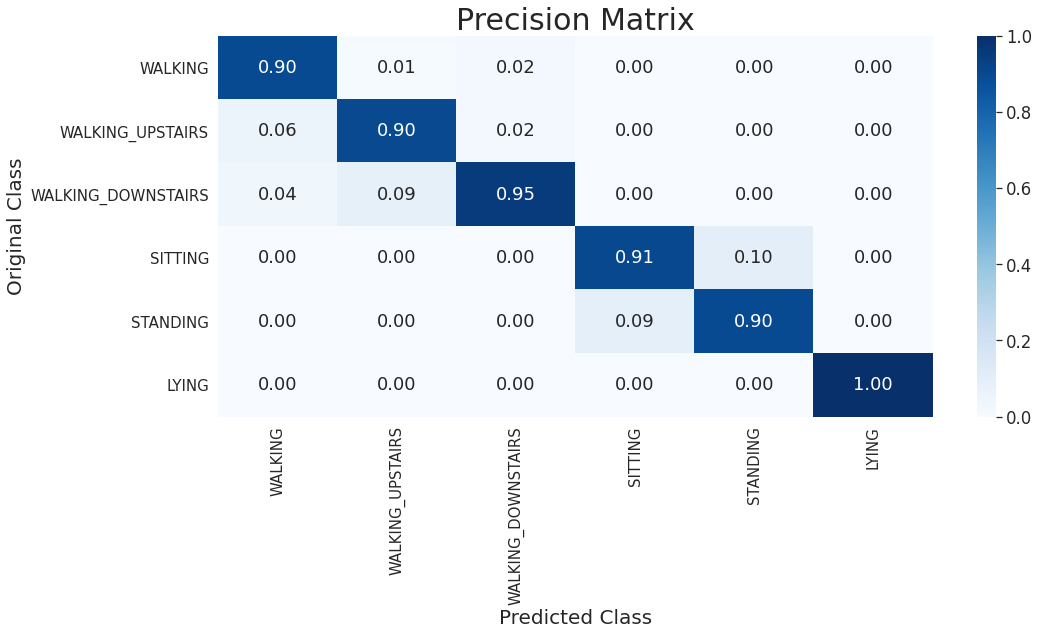

-----------------------------------------------------------------------------------------------------------------------------


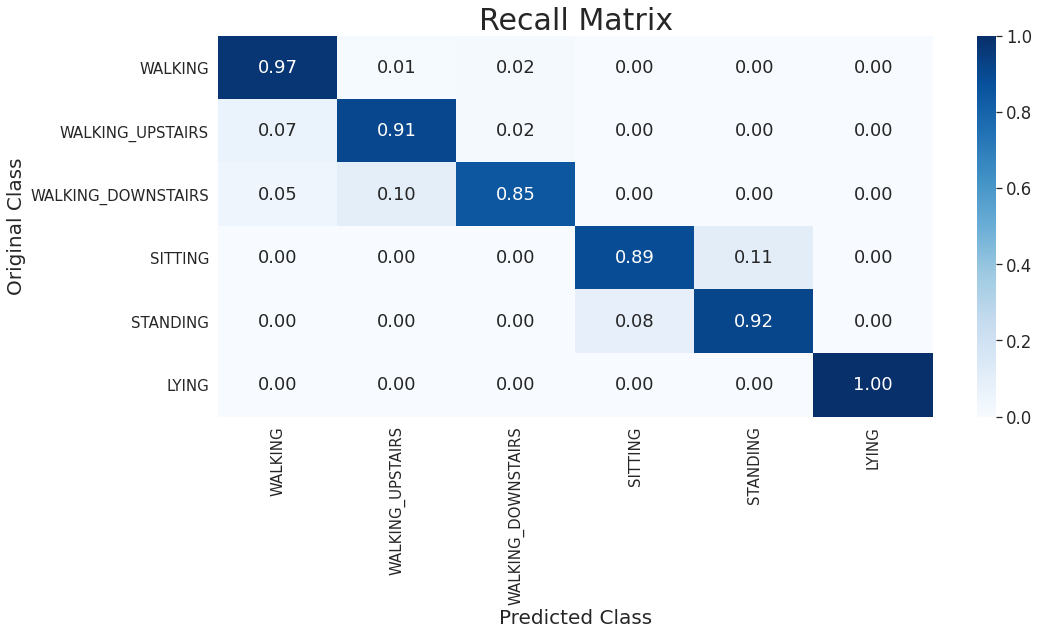

In [64]:
parameters = {"n_estimators": [50, 100, 200, 400, 800]}
clf = RandomForestClassifier()
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "Random Forest")

## 8.6 Gradient Boosted Decision Trees

The total time spent setting hyperparameters and producing model predictions is (HH:MM:SS): 0:53:42.753331

|------Accuracy------|
90.8%

|------Best Estimator-------|
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

|------Best Hyper-Parameters------|
{'max_depth': 1, 'n_estimators': 100}





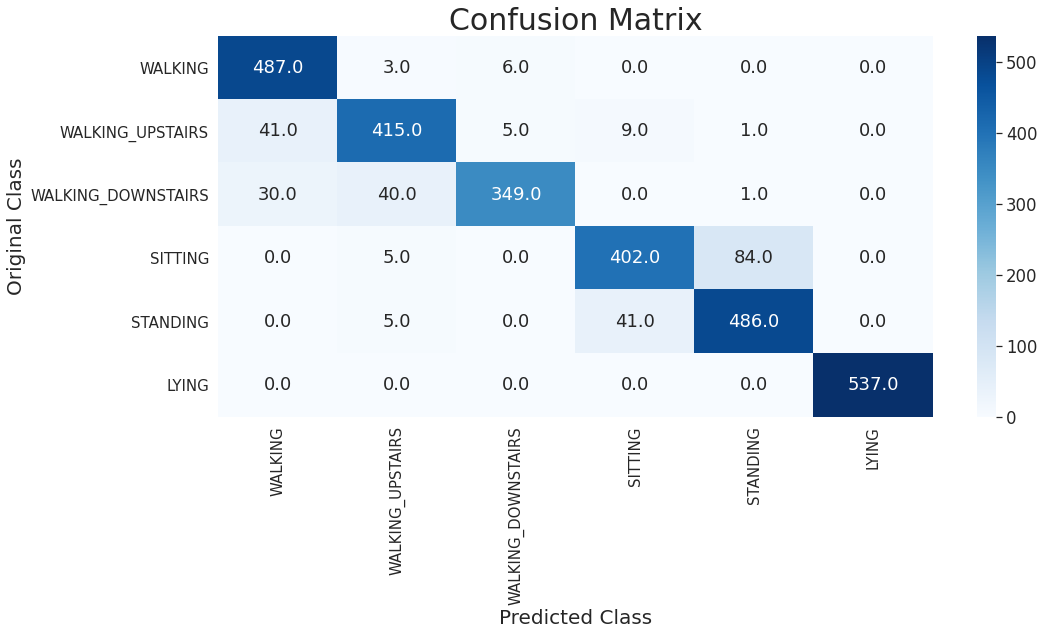

-----------------------------------------------------------------------------------------------------------------------------


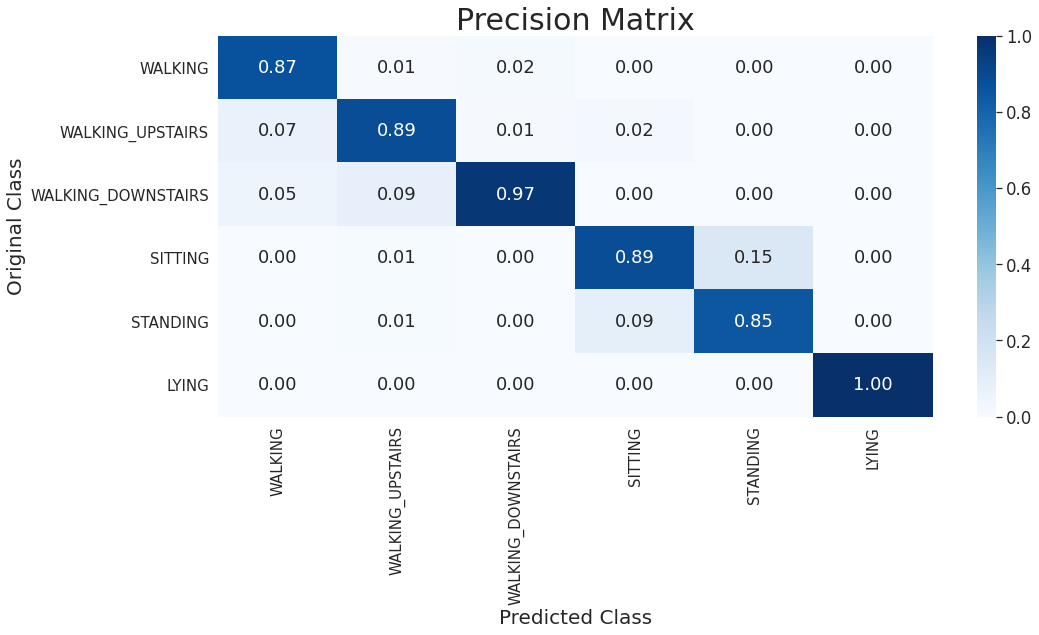

-----------------------------------------------------------------------------------------------------------------------------


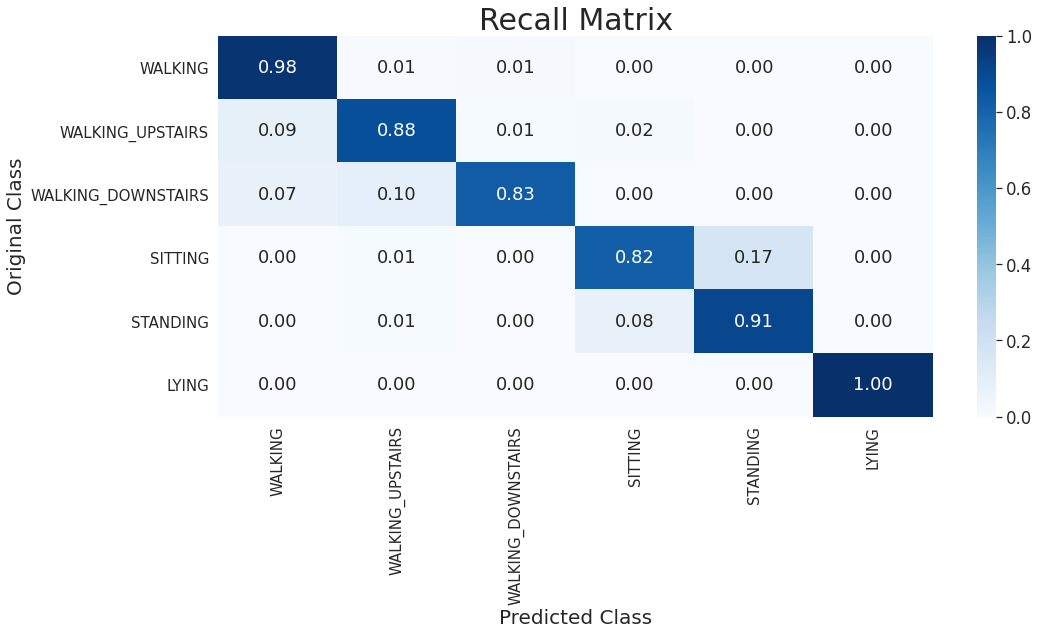

In [65]:
parameters = {"n_estimators": [50, 100], "max_depth":[1, 3]}
clf = GradientBoostingClassifier()
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "Gradient Boosted DT")

## 9. Model Comparison

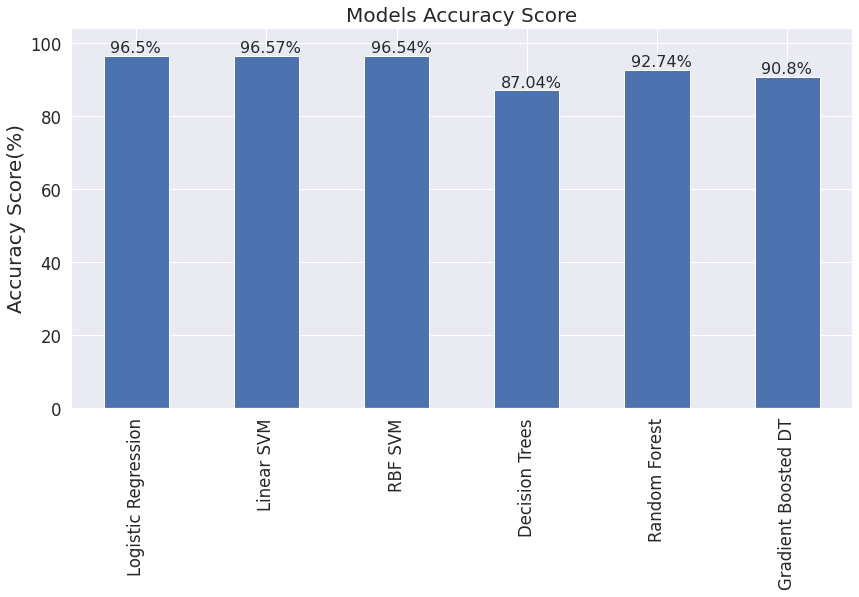

In [66]:
ax = table.plot(x = "Model", y = "Accuracy(%)", kind = "bar", figsize = (14, 7), legend = False)
plt.title("Models Accuracy Score", fontsize = 20)
plt.xlabel("")
plt.margins(x = 0, y = 0.08)
plt.ylabel("Accuracy Score(%)", fontsize = 20)
plt.grid(visible = True)
for i in ax.patches:
    ax.text(x = i.get_x()+0.05, y = i.get_height()+1, s = str(i.get_height())+"%", fontsize = 16, color = "#232b2b")

In [67]:
table

,Model,Accuracy(%)
0,Logistic Regression,96.50
1,Linear SVM,96.57
2,RBF SVM,96.54
3,Decision Trees,87.04
4,Random Forest,92.74
5,Gradient Boosted DT,90.80


Results:
Models such as Logistic Regression, rbf SVM, and Linear SVM have a 96 percent accuracy rate. Domain knowledge is one of the most significant parts of machine learning modeling in the actual world. We achieved a really good accuracy of over 96 percent in this case. This is largely owing to the fact that signal processing domain experts have meticulously built features.